# Affichage en diagramme de Gantt d'un ordonnancement 

L'objectif est d'utiliser et modifier les fonctions d'ordonnancement, de coût et d'affichage pour pouvoir visualiser un planning sous forme de Gantt.

Vocabulaire utilisé : 

- 'Ordonnancement' : liste de temps de prise en charge de patients sous la forme [ [ tempsBrancardage, tempsSSPIEntree, tempsBloc, tempsSSPIRéveil, idPatient, idChirurgien, tempsSejour ] pour chaque patient ]
- 'Phase' : Une phase désigne une des 4 phases de prise en charge d'un patient (Brancardage, SSPIEntree, Bloc, SSPIRéveil)
- 'Ressource' : Une ressource désigne l'une des "machines" réelles qui prennent en charge le patient (ex: Brancardier 1, lit d'entrée 3, Bloc 4, Lit de réveil 2)
- 'Patient' : Un patient correspond à une liste [ identifiant patient, début tache dans la phase, duree tache dans la phase, id chirurgien, temps de séjour ], cette donnée est différente d'une phase à l'autre pour un même patient
- 'Arrangement' : Regroupement de l'ordre de passage des patients pour chaque phase et leurs ressources, avec les patients au format ci-dessus

In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
import copy 

In [2]:
# Vacations : 
dicChir = {0:'CA', 1:'SC', 2:'CH', 3:'MA', 4:'JA', 5:'DO', 6:'LU', 7:'PI', 8:'LO', 9:'FR'}

vac = [[[], [0, 450], [], [], [0, 570], [], [330, 240], [0, 240], [], [0, 510]],
       [[], [], [0, 360], [0, 540], [0, 480], [], [], [], [], []],
       [[0, 360], [], [], [], [], [0, 480], [], [0, 300], [0, 270], []],
       [[], [0, 480], [0, 360], [], [], [], [0, 420], [], [], []],
       [[0, 300], [], [], [], [], [0, 360], [], [], [], []]]

print(dicChir)

{0: 'CA', 1: 'SC', 2: 'CH', 3: 'MA', 4: 'JA', 5: 'DO', 6: 'LU', 7: 'PI', 8: 'LO', 9: 'FR'}


def choixRessource(phase):
    """Soit phase une liste de ressources, cette fonction détermine quelle ressource prend la tâche"""
    
    mini = phase[0][-1][1]+phase[0][-1][2]
    index = 0
    
    found = False
    iRessource = 0
    
    while (not found) and iRessource < len(phase):
        ressource = phase[iRessource]
        if ressource == [[0,0,0,0,0]]:
            found = True
            index = iRessource
        elif ressource[-1][1]+ressource[-1][2] < mini:
            mini = ressource[-1][1]+ressource[-1][2]
            index = iRessource
        iRessource+=1
            
    return index

In [83]:
def genOrdoAvecChirurgien(n_patient, n_chir):
    """Génère un ordonnancement au hasard -> Sert uniquement en test"""
    
    return [[random.randint(5,10),random.randint(10,30),random.randint(40,120),random.randint(10,30), i, random.randint(0, n_chir), random.randint(1,5)] for i in range(n_patient)]

def placePatient(ressource, debutTache, finTache):
    """Renvoi l'index où un patient devra être placé dans une ressource"""
    
    #print("appel de la fonction placePatient")
    
    if len(ressource) == 1:
        if debutTache > ressource[0][1] + ressource[0][2]:  # si y a un seul patient avant et que le patient à placer commence après la fin de la tâche alors on le met apres 
            iPatient = 1
        else:
            iPatient = 0
    else:    
        iPatient = 0
        found = False
        while (not found) and (iPatient < len(ressource) - 1):
            #print("je m'en sors ?")
            patientAvant = ressource[iPatient]
            patientApres = ressource[iPatient+1]
            found = (patientAvant[1] + patientAvant[2] <= debutTache) and (finTache <= patientApres[1])
            iPatient += 1

    return iPatient

def choixRessource(phaseActu, debutTache1, finTache1):
    """Soit phase une liste de ressources, cette fonction détermine quelle ressource prend la tâche, a quelle place, si un decalage est necessaire, et un nouvel arrangement s'il n'y a pas assez de ressources"""
    
    #print("appel de la fonction choixRessource")
    
    index = 0
    found = False
    nRessource = len(phaseActu)
    ressources = list(range(nRessource))
    random.shuffle(ressources)
    iRessource = 0
    
    # 1ere recherche : y a-t-il une ressources qui a de la place pour cette tache ?
    
    while (not found) and (iRessource < nRessource):
        ressource = phaseActu[ressources[iRessource]]
        if ressource == [[0,0,0,0,0]]:
            found = True
            index = ressources[iRessource]
        elif (not found) :  
            iPatient = 0
            chevauchement = False
            while (not chevauchement) and iPatient < len(ressource):
                patientDejaPlace = ressource[iPatient]
                debutTache2 = patientDejaPlace[1]
                finTache2 = patientDejaPlace[1] + patientDejaPlace[2]
                chevauchement = (debutTache2 <= debutTache1 < finTache2) or (debutTache2 < finTache1 <= finTache2) or ((debutTache1 <= debutTache2) and (finTache1 >= finTache2)) # il y a chevauchement de taches si : (la tache commence au sein d'une autre) ou (la tache se finit au sein d'une autre) ou (la tache englobe une autre tache)
                iPatient += 1
            found = (not chevauchement)
            index = ressources[iRessource]
            iRessource += 1
            #print("j'ai trouvé le brancardier")
    
    # S'il n'y avait pas de place pour placer le patient dans cette phase sans rien décaler, on va devoir essayer en décalant
    # On refait la même boucle que plus haut en décalant de 1 en amont tant qu'on ne trouve pas une place
    
    if (not found):
        #print("il a fallu décaler")
        random.shuffle(ressources)
        decalageNeg = 0
        foundNeg = False
        indexNeg = 0

        while (not foundNeg):
            iRessource = 0
            debutTache1 -= 1
            finTache1 -= 1
            decalageNeg -=1
            while (not foundNeg) and (iRessource < nRessource):
                ressource = phaseActu[ressources[iRessource]]
                iPatient = 0
                chevauchement = False
                while (not chevauchement) and iPatient < len(ressource):
                    patientDejaPlace = ressource[iPatient]
                    debutTache2 = patientDejaPlace[1]
                    finTache2 = patientDejaPlace[1] + patientDejaPlace[2]
                    chevauchement = (debutTache2 <= debutTache1 < finTache2) or (debutTache2 < finTache1 <= finTache2) or ((debutTache1 <= debutTache2) and (finTache1 >= finTache2)) # il y a chevauchement de taches si : (la tache commence au sein d'une autre) ou (la tache se finit au sein d'une autre) ou (la tache englobe une autre tache)
                    iPatient += 1
                foundNeg = (not chevauchement)
                indexNeg = ressources[iRessource]
                iRessource += 1
                
        if abs(decalageNeg) > 30:
            # On refait la même boucle vers l'aval

            random.shuffle(ressources)
            decalagePos = 0
            foundPos = False
            indexPos = 0

            while (not foundPos) :
                iRessource = 0
                debutTache1 += 1
                finTache1 += 1
                decalagePos +=1
                while (not foundPos) and (iRessource < nRessource):
                    ressource = phaseActu[ressources[iRessource]]
                    iPatient = 0
                    chevauchement = False
                    while (not chevauchement) and iPatient < len(ressource):
                        patientDejaPlace = ressource[iPatient]
                        debutTache2 = patientDejaPlace[1]
                        finTache2 = patientDejaPlace[1] + patientDejaPlace[2]
                        chevauchement = (debutTache2 <= debutTache1 < finTache2) or (debutTache2 < finTache1 <= finTache2) or ((debutTache1 <= debutTache2) and (finTache1 >= finTache2)) # il y a chevauchement de taches si : (la tache commence au sein d'une autre) ou (la tache se finit au sein d'une autre) ou (la tache englobe une autre tache)
                        iPatient += 1
                    foundPos = (not chevauchement)
                    indexPos = ressources[iRessource]
                    iRessource += 1
                
            #print("j'ai trouvé")
            if abs(decalageNeg) > 2 * decalagePos:
                return indexPos, decalagePos
            else:
                return indexNeg, decalageNeg
            
        else:
            return indexNeg, decalageNeg
        
    else:
        #print("j'ai trouvé sans décaler")
        return index, 0

def choixSSPIReveil(phaseActu, debutTache1, finTache1):
    """Choix du lit de SSPI de réveil (processus légèrement différent des autres phases)"""
    
    index = 0
    found = False
    place = -1
    decalageNecessaire = 0
    nRessource = len(phaseActu)
    ressources = list(range(nRessource))
    random.shuffle(ressources)
    iRessource = 0
    
    # 1ere recherche : y a-t-il une ressources qui a de la place pour cette tache ?
    
    while (not found) and (iRessource < nRessource):
        ressource = phaseActu[ressources[iRessource]]
        if ressource == [[0,0,0,0,0]]:
            found = True
            index = ressources[iRessource]
        elif (not found) :  
            iPatient = 0
            chevauchement = False
            while (not chevauchement) and iPatient < len(ressource):
                patientDejaPlace = ressource[iPatient]
                debutTache2 = patientDejaPlace[1]
                finTache2 = patientDejaPlace[1] + patientDejaPlace[2]
                chevauchement = (debutTache2 <= debutTache1 <= finTache2) or (debutTache2 <= finTache1 <= finTache2) or ((debutTache1 <= debutTache2) and (finTache1 >= finTache2)) # il y a chevauchement de taches si : (la tache commence au sein d'une autre) ou (la tache se finit au sein d'une autre) ou (la tache englobe une autre tache)
                iPatient += 1
            found = (not chevauchement)
            index = ressources[iRessource]
            place = placePatient(ressource, debutTache1, finTache1)
            iRessource += 1
    
    # S'il n'y avait pas de place pour placer le patient dans cette phase sans rien décaler, on va devoir essayer en décalant
    
    if (not found): # On va parcourir toutes les ressources, à la recherche de celle qui fait décaler le moins possible (seulement en aval dans ce cas)
        decalageNecessaire = 100000  # on met une valeur aberrante pour etre sur qu'elle soit remplacée par la suite
    
        for indRessource, ressource in enumerate(phaseActu):
            for indPatient, patient in enumerate(ressource[:-1]):
                if (0 <= patient[1] + patient[2] - debutTache1 <= decalageNecessaire) and (finTache1 < ressource[indPatient+1][1]):
                    decalageNecessaire = patient[1] + patient[2] - debutTache1
                    index = indRessource
                    place = indPatient + 1
                    found = True   # on a au moins une solution (a voir si elle est satisfaisante...)
                    
    if (not found):  # dernier essai, s'il n'y avait de la place nulle part on le place tout à la fin
        fins = [ressources[-1][1] + ressources[-1][2] for ressources in phaseActu]
        index = fins.index(min(fins))
        place = len(phaseActu[index])
        signedDecalage = phaseActu[index][-1][1] + phaseActu[index][-1][2] - debutTache1
            
    return index, place, decalageNecessaire   

def searchPatient(ind, phase):
    """Trouve le patient n°ind dans la phase *phase*"""
    
    found = False
    iPhase = 0
    
    while (not found) and iPhase < len(phase):
        ressource = phase[iPhase]
        iRessource = 0
        while iRessource < len(ressource):
            patient = ressource[iRessource]
            if patient[0] == ind:
                found = True
                reponse = patient
            iRessource += 1
        iPhase+=1
    
    if found:
        return reponse
    else: 
        print("bizarre je n'ai pas trouvé le patient")
        return None
    
def decalPhase(ind, phase, delai):
    """Cette fonction décale d'un temps delai le patient ind dans la phase *phase*"""
    
    found = False
    iPhase = 0
    
    while (not found) and iPhase < len(phase):
        ressource = phase[iPhase]
        iRessource = 0
        while iRessource < len(ressource):
            patient = ressource[iRessource]
            if patient[0] == ind:
                found = True
                phase[iPhase][iRessource][1] += delai
            iRessource += 1
        iPhase+=1
        
def searchChir(X, L):
    renvoi = 0
    for i in range(len(L)):
        if X in L[i]:
            renvoi = i
    return renvoi

def attributionBlocChir(nBloc, vac):
    """Fonction qui attribue intelligemment les chirurgiens aux blocs en fonction des vacations"""

    blocChir = [[] for i in range (nBloc)]  # ordre de défilement des médecins dans chaque bloc, ex: [[1, 9], [4], [7, 6, 3], []] (4e bloc pas utilisé)
    vac2 = [[i] + chir for i, chir in enumerate(vac) if chir != []]  # on fait le tri dans le tableau de vacations
    auBloc = []  # liste qui sert au suivi des chirurgiens déjà attribués à un bloc

    # Première boucle pour l'ouverture des blocs (dépend du nombre de chirurgiens qui commencent à h0)
    for chir in vac2:  # On attribue à un bloc différent tous les chirurgiens qui commencent à h0, s'il y en a plus que nBloc alors il va avec un autre
        if chir[1] == 0:
            blocChir[len(auBloc) % nBloc].append(chir[0])
            auBloc.append(chir[0])

    # Deuxième boucle qui attribue dans l'ordre croissant les chirurgiens qui commencent après d'autres chirurgiens
    while len(auBloc) < len(vac2):
        mini=100000
        # Boucle qui cherche l'indice dans vac2 du chirurgien qui commence le plus tôt après un autre
        for iChir, chir in enumerate(vac2):
            if (chir[0] not in auBloc) and chir[1]<mini:
                mini = chir[1]
                imini = iChir
        indBloc = sorted([chir for chir in vac2 if chir[0] in [bloc[-1] for bloc in blocChir if bloc != []]], key = lambda x: x[1] + x[2])[0][0]  # expression très compliquée qui détermine quel chirurgien, parmi les derniers à être au bloc, aura fini le plus tôt
        blocChir[searchChir(indBloc, blocChir)].append(vac2[imini][0])  # on attribue le premier chirurgien à commencer après un autre au bloc dont le dernier chirurgien attribué aura fini le plus tôt
        auBloc.append(vac2[imini][0]) # on met à jour les chirurgiens déjà attribués à un bloc
    
    return blocChir

def timeInVacation(vacation, debutBloc, ratio, dureeTache):
    return (vacation[0] + vacation[1]) - debutBloc > ratio * dureeTache

def debutPatientSuivant(phase, indicePatient):
    """Instant de début de la tâche du patient suivant dans la phase"""
    found = False
    iPhase = 0
    
    while (not found) and iPhase < len(phase):
        ressource = phase[iPhase]
        iRessource = 0
        while iRessource < len(ressource):
            patient = ressource[iRessource]
            if patient[0] == indicePatient:
                found = True
                reponse = phase[iPhase][iRessource+1][1]
            iRessource += 1
        iPhase+=1
    
    return reponse

def arrangementJournee(ordo, vacations, ratio = 0.7, h0 = 0, nSSPIEntree = 3, nSSPIReveil = 3, nBloc = 4, nChir = 5, nAnesthesiste = 8, nBrancardier = 2):
    """Construit l'arrangement final en prenant en compte toutes les contraintes de ressources et de capacité"""
    
    #print("appel de la fonction arrangementJournee")
    
    # Initialisation des listes de phases qui représentent le passage 
    # des patients dans chaque 'phase' : dans chaque phase il y a nPhase ressources
    # et dans chaque ressource il y aura des patients au format [id du patient, instant de début de la tâche, duree de la tâche, id du chirurgien, temps de séjour]
    
    ordresBrancardiers = [[[0, 0, 0, 0, 0]] for _ in range(nBrancardier)]
    ordresSSPIEntrees = [[[0, 0, 0, 0, 0]] for _ in range(nSSPIEntree)]
    ordresBlocs = [[[0, 0, 0, 0, 0]] for _ in range(nBloc)]
    ordresSSPIReveils = [[[0, 0, 0, 0, 0]] for _ in range(nSSPIReveil)]
    
    # Affectations des médecins à un bloc:
    
    blocChir = attributionBlocChir(nBloc, vacations)
    
    # Affectations des patients dans les emplois du temps
    
    for indBloc, bloc in enumerate(blocChir):                                                # On traite bloc par bloc ...
        #print(f"on traite le bloc {indBloc}")
        if bloc != []: # on vérifie que le bloc est ouvert ce jour-là
            for chir in bloc:                                            # ... afin d'affecter les patients chir par chir
                #print(f"on en est au chirurgien {chir}")
                iPatient = 0
                vacationDispo = True 
                while vacationDispo and iPatient<len(ordo):     # tant que l'on peut placer des patients dans la vacation
                    patient = ordo[iPatient]
                    if patient[5] == chir:                     # Si le patient est affilié à ce chirurgien
                        vacChir = vacations[chir]
                        # Choix du bloc : attribution prioritaire car c'est ce qu'on optimise, et les autres taches en dépendent
                        if ordresBlocs[indBloc][-1][3] == chir:    
                            readyTime = ordresBlocs[indBloc][-1][1] + ordresBlocs[indBloc][-1][2] + 10
                        else:
                            readyTime = vacChir[0]
                        if timeInVacation(vacChir, readyTime, ratio, patient[2]) : # est-ce qu'on a le temps de faire 70% de l'opération avant la fin de la vacation prévue
                            patient = ordo.pop(iPatient)
                            if ordresBlocs[indBloc] == [[0, 0, 0, 0, 0]] :     # Pour traiter les premiers cas, dû à l'initialisation, on remplace au lieu d'ajouter
                                ordresBlocs[indBloc] = [[patient[4], h0, patient[2], patient[5], patient[6]]]
                            else :
                                ordresBlocs[indBloc].append([patient[4], readyTime, patient[2], patient[5], patient[6]])
                                ordresBlocs[indBloc] = sorted(ordresBlocs[indBloc], key = lambda x: x[1])

                        # Choix du lit SSPI + attribution du patient:
                            blocPhase = searchPatient(patient[4], ordresBlocs) # On retrouve les données de ce patient au bloc
                            litSSPIEntree, decLit = choixRessource(ordresSSPIEntrees, blocPhase[1] - patient[1], blocPhase[1])

                            if ordresSSPIEntrees[litSSPIEntree] == [[0,0,0,0,0]] :   # Pour traiter les premiers cas, dû à l'initialisation, on remplace au lieu d'ajouter
                                ordresSSPIEntrees[litSSPIEntree] = [[patient[4], blocPhase[1]-patient[1], patient[1], patient[5], patient[6]]]
                            else : 
                                if decLit > 0:  # si c'est un décalage positif, on doit décaler le bloc puis placer le lit SSPI
                                    if timeInVacation(vacChir, blocPhase[1]+decLit, ratio, patient[2]):  # si le décalage ne déborde pas trop sur la vacation, on l'autorise
                                        decalPhase(patient[4], ordresBlocs, decLit)
                                        ordresSSPIEntrees[litSSPIEntree].append([patient[4], blocPhase[1]-patient[1]+decLit, patient[1], patient[5], patient[6]])
                                        ordresSSPIEntrees[litSSPIEntree] = sorted(ordresSSPIEntrees[litSSPIEntree], key = lambda x: x[1])
                                        print(f"passés par là en SSPI pour le patient {patient[4]}, decalage = {decLit}")
                                    else:    # sinon la vacation n'est plus disponible, on ne prend pas le patient en charge
                                        vacationDispo = False
                                        ordresBlocs[indBloc].pop(-1)
                                        ordo.insert(iPatient, patient)
                                else:
                                    ordresSSPIEntrees[litSSPIEntree].append([patient[4], blocPhase[1]-patient[1]+decLit, patient[1], patient[5], patient[6]])
                                    ordresSSPIEntrees[litSSPIEntree] = sorted(ordresSSPIEntrees[litSSPIEntree], key = lambda x: x[1])


                        # Choix du brancardier + attribution du patient:
                            if vacationDispo: # on vérifie qu'on est bien dans un cas où la vacation est dispo pour pas ajouter un patient pour rien en brancardage et sspi réveil

                                SSPIEntreePhase = searchPatient(patient[4], ordresSSPIEntrees) # On retrouve les données de ce patient au SSPI d'entree
                                brancardier, decBrancardage= choixRessource(ordresBrancardiers, SSPIEntreePhase[1] - patient[0], SSPIEntreePhase[1])

                                if ordresBrancardiers[brancardier] == [[0,0,0,0,0]] : # Pour traiter les premiers cas, dû à l'initialisation, on remplace au lieu d'ajouter
                                    ordresBrancardiers[brancardier] =  [[patient[4], SSPIEntreePhase[1] - patient[0], patient[0], patient[5], patient[6]]]
                                else : 
                                    if decBrancardage > 0:
                                        
                                        decalageSSPIEntreePossible = debutPatientSuivant(ordresSSPIEntrees, patient[4])-(SSPIEntreePhase[1]+SSPIEntreePhase[2]) > decBrancardage   # On vérifie qu'il y a la place de déplacer le sspi d'entree et le bloc
                                        if decalageSSPIEntreePossible and timeInVacation(vacChir, SSPIEntreePhase[1]+decBrancardage, ratio, patient[2]):
                                            decalPhase(patient[4], ordresBlocs, decBrancardage)
                                            decalPhase(patient[4], ordresSSPIEntrees, decBrancardage)
                                            ordresBrancardiers[brancardier].append([patient[4], SSPIEntreePhase[1]-patient[0]+decBrancardage, patient[0], patient[5], patient[6]])
                                            ordresBrancardiers[brancardier] = sorted(ordresBrancardiers[brancardier], key = lambda x: x[1])
                                            print(f"passés par là en brancardage pour le patient {patient[4]}, decalage = {decBrancardage}")
                                        else:    # S'il n'y a pas la place pour le décalage on avorte l'attribution de ce patient au bloc
                                            print("problème lors du décalage aval en SSPI à cause du brancardage")
                                            vacationDispo = False
                                            ordresBlocs[indBloc].pop(-1)
                                            ordresSSPIEntrees[litSSPIEntree].pop(indiceLit)
                                            ordo.insert(iPatient, patient)
                                    else:
                                        ordresBrancardiers[brancardier].append([patient[4], SSPIEntreePhase[1]-patient[0]+decBrancardage, patient[0], patient[5], patient[6]])
                                        ordresBrancardiers[brancardier] = sorted(ordresBrancardiers[brancardier], key = lambda x: x[1])

                                if vacationDispo:
                                # Choix du lit SSPIReveil
                                    previousPhase = searchPatient(patient[4], ordresBlocs) # On retrouve ses données à la phase précédente
                                    litSSPIReveil, indiceLitReveil, decLitReveil = choixSSPIReveil(ordresSSPIReveils, previousPhase[1] + previousPhase[2], previousPhase[1] + previousPhase[2] + patient[3])
                                    if ordresSSPIReveils[litSSPIReveil] == [[0,0,0,0,0]] :   # Pour traiter les premiers cas, dû à l'initialisation, on remplace au lieu d'ajouter
                                        ordresSSPIReveils[litSSPIReveil] = [[patient[4], previousPhase[1] + previousPhase[2], patient[3], patient[5], patient[6]]]
                                    else : 
                                        ordresSSPIReveils[litSSPIReveil].append([patient[4], previousPhase[1] + previousPhase[2] + decLitReveil, patient[3], patient[5], patient[6]])
                                        ordresSSPIReveils[litSSPIReveil] = sorted(ordresSSPIReveils[litSSPIReveil], key = lambda x: x[1])
                                        
                        else:
                            vacationDispo = False
                    else:
                        iPatient+=1
    
    return [ordresBrancardiers, ordresSSPIEntrees, ordresBlocs, ordresSSPIReveils]

def coutOrdo(arrangement):
    """Prend en entree un arrangement et donne son coût temporel total"""
    
    brancardiers = arrangement[0]
    debut = min([brancardier[0][1] for brancardier in brancardiers])  # date de debut minimale de tous les brancardiers (forcément parmi les premières prises en charge de chacun)
    
    litsReveil = arrangement[-1]
    fin = max([lit[-1][1]+lit[-1][2] for lit in litsReveil]) # date de fin maximale de tous les lits de réveil (parmi leur dernière prise en charge)
    
    return fin - debut

def attenteOrdo(arrangement):
    """Prend en entree un arrangement et donne la somme de toutes les attentes des patients"""
    
    patients = []
    for ressource in arrangement[0]:
        patients += [patient[0] for patient in ressource]
    # n est le nombre de patient dans l'arrangement    
    attente = 0
    
    for patient in patients :
        branc, sspi1, bloc, sspi2 = searchPatient(patient, arrangement[0]), searchPatient(patient, arrangement[1]), searchPatient(patient, arrangement[2]), searchPatient(patient, arrangement[3])
        attenteBr = sspi1[1] - (branc[1] + branc[2])
        if attenteBr > 0 :
            attente += attenteBr
            #print(f"Je suis le patient {patient} et j'ai attendu {attenteBr} minutes en brancardage")
        attentesspi1 = bloc[1] - (sspi1[1] + sspi1[2])
        if attentesspi1 > 0 :
            attente += attentesspi1
            #print(f"Je suis le patient {patient} et j'ai attendu {attentesspi1} minutes en SSPI d'entrée")
        attenteBl = sspi2[1] - (bloc[1] + bloc[2])
        if attenteBl > 0 :
            attente += attenteBl
            #print(f"Je suis le patient {patient} et j'ai attendu {attenteBl} minutes au bloc")
    
    return attente

def nbPatients(arrangement):
    nb = 0
    for i in arrangement[0]:
        nb += len(i)
    return nb

def cout(arrangement):
    """Prend en entree un ordonnancement et donne son coût temporel total et la somme de toutes les attentes des patients"""
    
    cout, attente, nbPat = coutOrdo(arrangement), attenteOrdo(arrangement), nbPatients(arrangement)
    
    return cout, attente, nbPat

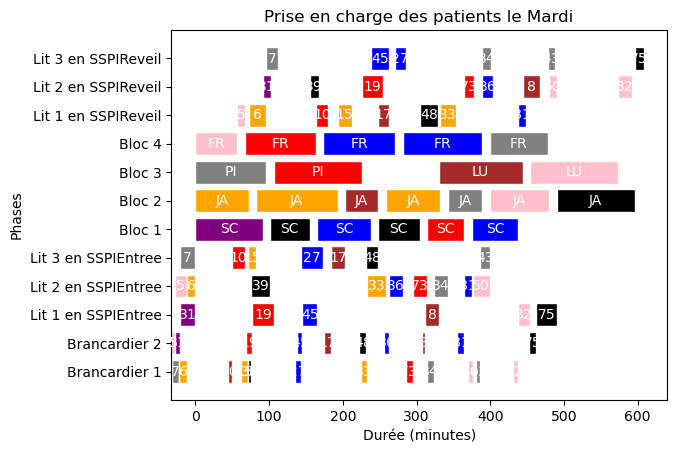

(641, 13, 22)


In [89]:
def emploiDuTemps(arrangement, jour):
    """Affiche sous forme de diagramme en barre l'emploi du temps global d'un arrangement"""

    Jours = ["Lundi", "Mardi", "Mercredi", "Jeudi", "Vendredi"]
    titres = [f"Brancardier {i+1}" for i in range(len(arrangement[0]))] + [f"Lit {i+1} en SSPIEntree" for i in range(len(arrangement[1]))] + [f"Bloc {i+1}" for i in range(len(arrangement[2]))] + [f"Lit {i+1} en SSPIReveil" for i in range(len(arrangement[3]))]
    couleurs = ['blue', 'red', 'green', 'black', 'purple', 'pink', 'orange', 'grey', 'brown']

    # Créer un graphique en barres horizontales
    ind = 0
    for iPhase, phase in enumerate(arrangement):
        for ressource in phase:
            for patient in ressource:
                plt.barh(titres[ind], left=patient[1], width = patient[2], color=couleurs[patient[0]%len(couleurs)], edgecolor='white')
                if iPhase == 2:
                    plt.text(patient[1]+patient[2]/2, ind, dicChir[patient[3]], ha='center', va='center', color = 'white')
                else:
                    plt.text(patient[1]+patient[2]/2, ind, str(patient[0]), ha='center', va='center', color = 'white')
            ind += 1

    # Ajouter des étiquettes d'axe et un titre
    plt.xlabel("Durée (minutes)")
    plt.ylabel("Phases")
    plt.title(f"Prise en charge des patients le {Jours[jour]}")

    plt.show()
    
#ordo = genOrdoAvecChirurgien(100, 10)
#arrangement = arrangementJournee(ordo, vac[0])
#emploiDuTemps(arrangement, 1)
#print(cout(arrangement))


# Cellule à lancer pour afficher l'emploi du temps de la semaine 

Ordonnancement aléatoire et vacations tirées de la base de données début 2019 (pas à jour ni complet)

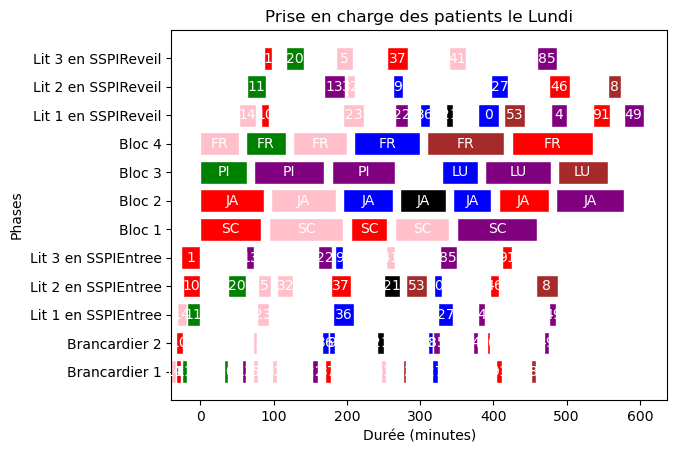

(645, 28, 24)


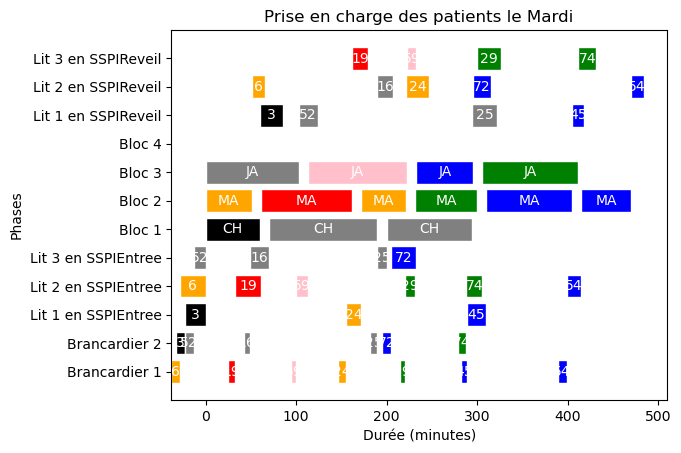

(522, 0, 13)


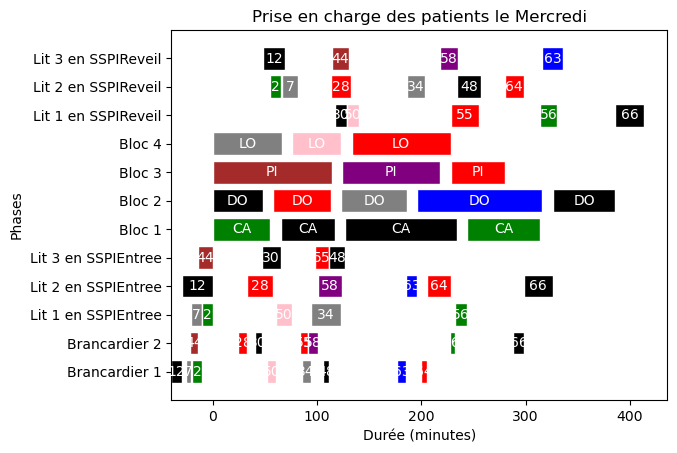

(453, 45, 15)


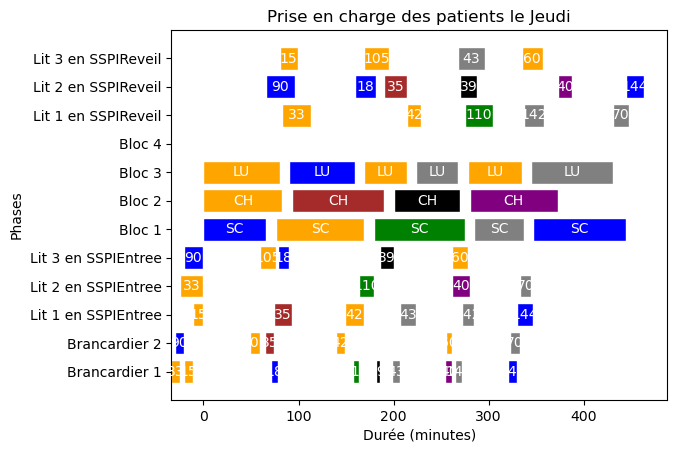

(497, 0, 15)


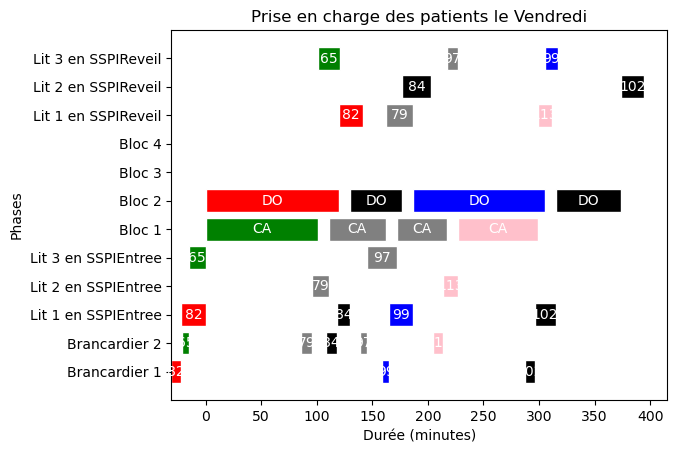

(425, 0, 8)


In [91]:
def arrangementSemaine(ordo, vacations):
    semaine = []
    for i in range(5):
        semaine.append(arrangementJournee(ordo, vacations[i]))
    return semaine

ordo = genOrdoAvecChirurgien(10000, 10)
semaine = arrangementSemaine(ordo, vac)

def emploiDuTempsSemaine(semaine):
    for jour, arrangement in enumerate(semaine):
        emploiDuTemps(arrangement, jour)
        print(cout(arrangement))

emploiDuTempsSemaine(semaine)
        

Améliorations : 

- créer un algorithme qui détermine combien de places en SSPI et de brancardiers sont nécéssaires pendant une certaine période ?
- que faire si il n'y a plus de place pour décaler le SSPI d'entree ? (soit on laisse l'avortement de l'ajout du patient et ce sera pénalisé par le fait qu'on traite moins de patients, soit on l'ajoute à la toute fin et ce sera pénalisé par le temps d'ouverture de bloc)